# The Parker Spiral with Python

In this post, we will explore the numerical solution to the first-order nonlinear differential equation that models the solar wind speed as a function of the heliocentric distance. Once this velocity profile is obtained, which is temperature-dependent, we proceed to transform it into Lagrangian coordinates centered at an emission point on the corona. This will make it more natural to construct an arm of the Parker spiral, along which the found velocity profile evolves.

When we talk about the "Parker spiral", we refer to the shape of the Sun's magnetic field in our solar system as a result of its rotation and the magnetohydrodynamic interaction with the expanding solar wind. This generates a swirling shape in the description of the magnetic field, which we will see how to obtain using Python.

## Solar wind

[Solar wind](https://en.wikipedia.org/wiki/Solar_wind) is a flow of charged particles (mainly electrons $e^-$, protons $p^+$ and alpha particles $\alpha$), emitted from the solar atmosphere. These charged particles (ionized gas or plasma), escape the gravitational attraction of the Sun due to their high kinetic energy resulting from the temperature of the corona solar and interaction with the magnetic field.

The first mentions of its existence date back to Biermann in the 1950s, who through the observation of comet tails (in the opposite direction of the sun), suggested that there should be a flow of gas towards the outside of the Sun in a radial direction. Parker takes this observation and assumes the Sun as a gravitating mass with spherical symmetry in expansion stationary (with the aim to ensure zero pressure condition at infinite distance) and initially disregarding the effects of the magnetic field. With these considerations, it is possible to manifest the dynamics of the flow of charged particles towards the outside of the Sun (Parker, 1958).

## Solar Wind Velocity Profile

In Parker's work under conditions of isothermal expansion ($\gamma = 1$) of a neutral fluid (first approximation to the behavior of the solar wind), it leads to a non-linear first-order differential equation that relates the solar wind speed ($u(r)$) and the heliocentric distance ($r$). (Parker, 1958), (Kivelson, 1995)

\begin{equation}
\frac{du(r)}{dr} = \left(\frac{4kT}{mr} - \frac{GM}{r^2} \right)u(r)\left(u(r)^2 - \frac{2kT}{m} \right)^{-1}
\end{equation}

In order to reduce the propagation of errors due to orders of magnitude of the variables involved, the differential equation is adimensionalized based on the radius and velocity at the critical point (sonic point) (Piso, 2008).

\begin{eqnarray}
c_s^2 & = & \frac{2kT}{m}\\
r_c &=& \frac{GM}{2c_s^2}\\
\frac{dv}{dR} &=& \frac{2\left(\frac{1}{R} - \frac{1}{R^2}\right)}{v - \frac{1}{v}}
\end{eqnarray}

Where $v$ is the speed at sonic velocities ($c_s$) and $R$ is the radius at sonic radii ($r_c$). We observe that around the sonic radius and speed, there is a critical point that must be satisfied to ensure the physical meaning of the solution. Also, we have to note that this equation represents a boundary value problem, and in this case, the boundary condition of the problem in adimensional units is $v(R_{\text{sun}}) = v_0$, where $R_{\text{sun}}$ is the radius of the Sun, and it is the position from which the flow of particles begins to move with an initial speed $v_0$ that depends on the density of particles and temperature.

The generation of the Parker spiral is due to the rotation of the Sun, so we apply the transformation of coordinates Lagrangian for rotating systems, leading to the differential equation:
\begin{equation}
\frac{d\varphi}{dR} = \frac{-\omega}{v(R)}
\end{equation}

## Analytical and numerical solution to Parker equation with Python

This equation can be solved analytically because the equation allows for separation of variables and by integration to find the implicit solution. We can use [SymPy](https://www.sympy.org/), a free and open-source computational algebra package available in Python (an alternative to commercial packages such as Maple and Mathematica).

Regarding numerical solutions, we will implement the method of [Runge-Kutta 4 (RK4)](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_method#Fourth_order_Runge%E2%80%93Kutta_methods), and for the angular component solution, we will do it simply with the [Euler's method](https://en.wikipedia.org/wiki/Euler_method) since this avoids having to interpolate the radial velocity solution to find intermediate points required by RK4. To implement this, we will need to manage arrays, and that's what we'll use with [NumPy](https://numpy.org/). Of course, we want to visualize the solution so we can understand it, so we'll use [Matplotlib](https://matplotlib.org/).

So, let's install, in this case, with UV's help, [which is a faster alternative to pip and venv](project:/en/blog/2024/uv-alternativa-rapida-a-pip-y-venv.md). The `!` symbol is because it's a Notebook cell, but if you're in the terminal, you can omit it.

In [1]:
!uv pip install matplotlib numpy sympy

Using Python 3.12.7 environment at: /home/cosmoscalibur/Documentos/git/cosmoscalibur.github.io/.venv
Resolved 13 packages in 515ms                                        
Installed 2 packages in 77ms                                
 + mpmath==1.3.0
 + sympy==1.13.3


We start by importing the necessary elements we will need. Each line is commented to explain why we require it, making its use clear.

In [2]:
from math import cos, pi, sin  # Required for polar transformation to illustrate solution of spiral

from IPython.display import display
# To include graphics in the Notebook instead of pop-up windows
#%matplotlib inline
import matplotlib.pyplot as plt  # Plotting library for numerical arrays
from numpy import array, ones  # Numerical arrays and a fixed value array
from sympy import (
    dsolve,  # Solver for ordinary differential equations
    Eq,  # Allows setting up equations
    Function,  # Declares variables that represent functions
    init_printing,  # Initializes display options for notebooks
    plot_implicit,  # Enables plotting of implicit functions
    solve,  # Solution to algebraic equations
    symbols  # Declares general symbols
)
init_printing()  # Initializes printing session in the Notebook

### Analytical solution using SymPy

The first step is to declare the required symbols. This is the function for speed profile and the symbol for distance from the center of the Sun. The functions are declared with `Function` and variables with `symbols`. In both cases, the argument is a string representing the letter that corresponds to the symbol, and we assign it to a Python variable with the same letter.

Additionally, we will set up the equation that we previously obtained in adimensional form. We need to take into account that speed is a function, so we write it as usual, indicating its form with parentheses and the variable it depends on, $v(R)$. To express the derivative, SymPy supports the method `.diff` whose argument is the variable with respect to which we differentiate. In this case, we would set up as `v(R).diff(R)`.

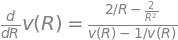

In [3]:
v = Function('v')  # Define speed function
R = symbols('R')  # Define distance variable
# Specify differential equation
eq_ord = Eq(v(R).diff(R), 2*(1/R - 1/R**2)/(v(R) - 1/v(R)))
eq_ord

SymPy supports the method of separation of variables. If we need a specific form or want to hint to the algorithm, we can add an option that recommends the method. In this case, it would be `hint='separable'`. However, since our case is not separable, we don't use this option.

For our specific problem, it's essential to indicate the method so that later the option of no simplification will show us the typical equation described in Parker's article. The function for solving ordinary differential equations is `dsolve`.

In [4]:
# Apply separable variable method
# Not simplify to show implicit form
sol_impl = dsolve(eq_ord, hint='separable', simplify=False)
sol_impl

For curious readers, we can also allow the solution to be simplified and obtain an explicit form that depends on the [Lambert W function](https://en.wikipedia.org/wiki/Lambert_W_function). This is not the usual form in which the solution will be referenced, but thanks to computer algebra systems, we can dispense with this since the 1990s. To do so, we can remove the option of no simplification, and also if we remove the method recommendation, we will also obtain the Lambert W function.

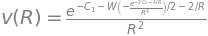

In [5]:
dsolve(eq_ord)

To determine which values of the constant of integration to use, we need to consider that the solution must satisfy passing through the critical point. Therefore, by assigning a value to the critical point, we can solve for the constant. To make this substitution, we use the method `.subs`, which takes a dictionary where keys are original symbols and values are new values or symbols.

In [6]:
solve(sol_impl.subs({v(R): 1, R: 1}))

To plot the solution, we need to replace the velocity function with a symbol and proceed with changes of the constant of integration to generate the family of solutions. Since we already know that for passing through the critical point, the constant must be $-3/2$, we will use this value, but also need an upper bound (e.g., $1$) and a lower bound (e.g., $2$). To graph the implicit function, we will use SymPy's `plot_implicit` method, which creates a grid of points in the plane of interest to evaluate if the equality holds. We will use `show=False` so that each curve is not shown separately, allowing us to add all three scenarios in one plot.

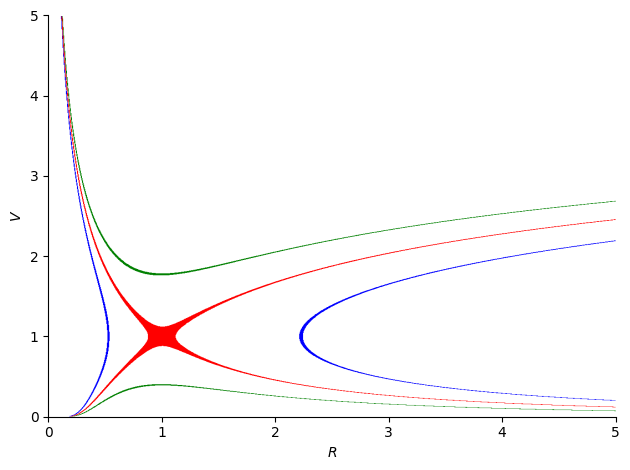

In [7]:
V = symbols('V')  # Define velocity variable
# Implicit plot to 3 values of constant integration
# show=False to manipulate plot as unique canvas
p1 = plot_implicit(
    sol_impl.subs({'C1': -1, v(R): V}),
    (R, 0, 5),
    (V, 0, 5),
    line_color='green',
    show=False
)
p2 = plot_implicit(
    sol_impl.subs({'C1': -2, v(R): V}),
    (R, 0, 5),
    (V, 0, 5),
    line_color='blue',
    show=False
)
p3 = plot_implicit(
    sol_impl.subs({'C1': -1.5, v(R): V}),
    (R, 0, 5),
    (V, 0, 5),
    line_color='red',
    show=False
)
p1.extend([p2[0], p3[0]])  # append curve plots to same axes
p1.show()  # Show plot

The blue curves are referred to as Solutions I and II. They are solutions of double evaluation and therefore are not physically acceptable solutions. The rightmost blue curve (II) also does not start on the surface of the Sun, while the leftmost blue curve (I) makes no physical sense since it would escape from the Sun with a subsonic velocity and return with a supersonic velocity.

The green curves (III - upper, IV - lower) are solutions that do not pass through the critical point and therefore are not physically acceptable. Additionally, Curve III starts with a supersonic velocity near the Sun, which has not been observed, while Curve IV leads to constant pressure in the interstellar medium, which makes no physical sense.

In contrast, the red ascending curve (V) leads to an increase in velocity after the critical point, which is observed, but also leads to zero pressure in the interstellar medium. This is known as the solar wind solution.

:::{attention}

At the level of the graph, a dense zone is observed around the critical point, but this is an effect of the implicit plotting method used with adaptive rendering.
:::

### Numerical solution

It is observed that at the critical point $(r_c, c_s)$, there is an indeterminacy. For this reason, it is necessary to solve the differential equation before and after this point as two independent intervals. The first interval, to ensure its passage through the critical point, is recommended to be solved with a backward form, so that we can use this information as an initial condition in the differential equation instead of making an estimate of the initial conditions on the solar radius (which would be the same for both intervals).

Therefore, we have to set $v(1) = 1$, for the first tramm that goes from the radius of the coronal solar up to the critical point, and the second interval that goes from the critical point to Earth (having a reference point for the solution going forward).

We define the function for numerical values on the right-hand side of the differential equation ($\frac{d}{dR}v(R)$) in `f_ode` and define our function for the RK4 method, `RK4`.

In [8]:
def f_ode(R, v):
    # Derivative of velocity profile function
    return 2 * (1/R- 1/R**2)/(v-1/v)

def RK4(funcion, cond_inicial, x_final, n):
    # RK4 solver
    x = [cond_inicial[0]]
    w = [cond_inicial[1]]
    dx = (x_final - x[0]) / n # step
    dx_2 = dx / 2 # half step
    for i in range(n-1):
        k1 = dx * funcion(x[i], w[i])
        k2 = dx * funcion(x[i] + dx_2, w[i] + k1/2)
        k3 = dx * funcion(x[i] + dx_2, w[i] + k2/2)
        x.append(x[i] + dx) # x[i+1] = x[-1]
        k4 = dx * funcion(x[-1], w[i] + k3)
        w.append(w[i] + (k1 + 2*k2 + 2*k3 + k4)/6)
    return x, w

Define required constants and helper functions to compute sonic velocity and sonic radii.

In [9]:
G = 6.67e-11 #Nm2kg-2
k = 1.38065e-23 #JK-1
M = 1.988435e30 #kg, Sun mass
m_H = 1.67372e-27 #kg, hydrogen mass
r_max = 150e9 #m, Earth-Sun distance
r_min = 695.5e6 #m, Sun radii
omega_sol = 2.7e-6 #rads-1, Sun angular velocity
T_cor = 1e6 #K, Corona temperature

def c_s(T = T_cor, m = m_H):
    # Sonic velocity
    from math import sqrt
    return sqrt(2*k*T/m)

def r_c(T = T_cor, m = m_H):
    # Sonic radii
    return G*M / (2 * c_s(T, m)**2)

Define adiminensional parameters 

In [10]:
vel_s = c_s(T_cor, m_H)
rad_s = r_c(T_cor, m_H)
t_s = rad_s / vel_s
print("Sonic velocity: {:f}km/s".format(vel_s/1000))
print("Sonic radii: {:f}km".format(rad_s/1000))
print("Unit time: {:f}s".format(t_s))
omega_s = omega_sol * t_s
print("omega (adim): {:f}".format(omega_s))
R_max = r_max / rad_s
R_min = r_min / rad_s
print("Max radii (adim): {:f}".format(R_max))
print("Min radii (adim): {:f}".format(R_min))

Sonic velocity: 128.444465km/s
Sonic radii: 4019540.880399km
Unit time: 31293.998427s
omega (adim): 0.084494
Max radii (adim): 37.317695
Min radii (adim): 0.173030


Now we apply the RK4 method for the segments and graph the results. It is important to note that since the first segment is reversed, in order to properly arrange the solution, we need to apply the reverse of the list (`.reverse`) and thus keep the solution ordered.

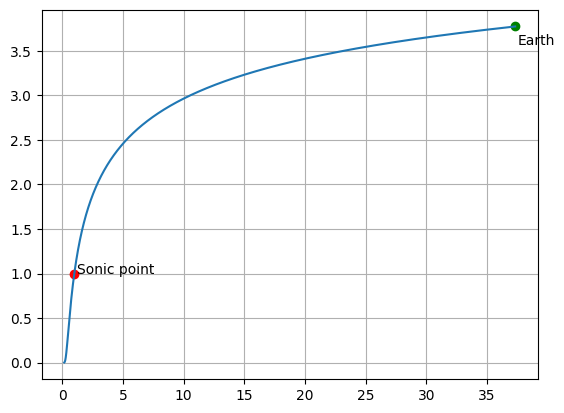

In [11]:
# Numerical solution to solar wind equation
R, v = RK4(f_ode, [1, 1-1e-6], R_min, 30000)
R.reverse()
v.reverse()
R_sup, v_sup = RK4(f_ode, [1, 1+ 1e-6 ], R_max, 1000000)
v.extend(v_sup)
R.extend(R_sup)
# Graficamos
plt.plot(1, 1, 'or')
plt.text(1.2, 1, 'Sonic point')
plt.plot(R[-1], v[-1], 'og')
plt.text(R[-1] + .2, v[-1]-.2,'Earth')
plt.plot(R, v)
plt.grid()
plt.show()

Starting from this velocity profile, we construct the angular velocity component to ultimately generate the well-known Parker spiral, and we can do this using the Euler method.

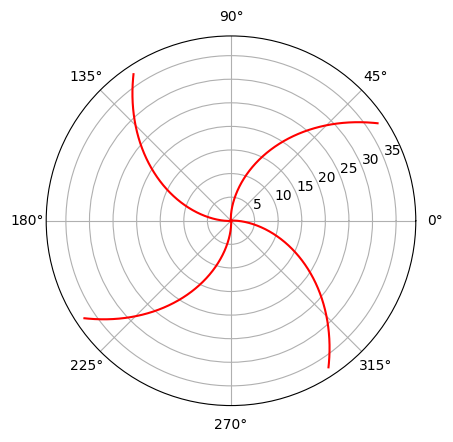

In [12]:
N = len(R)
cont = 0
psi = [0]
x = [R[0]*cos(psi[0])]
y = [R[0]*sin(psi[0])]
while cont < N-1:
    # Euler method
    dR = R[cont + 1] - R[cont]
    dpsi = -omega_s * dR / v[cont]
    psi.append(psi[-1] + dpsi)
    cont = cont + 1

dpsi_v = ones([N]) * pi / 2
psi1 = array(psi)
psi2 = psi1 + dpsi_v
psi3 = psi2 + dpsi_v
psi4 = psi3 + dpsi_v
espiral = plt.subplot(111, projection='polar')
espiral.plot(psi1, R, color='r')
espiral.plot(psi2, R, color='r')
espiral.plot(psi3, R, color='r')
espiral.plot(psi4, R, color='r')

# Referencias  

- E. N. Parker, ["Dynamics of the Interplanetary Gas and Magnetic Fields"](https://articles.adsabs.harvard.edu/pdf/1958ApJ...128..664P), Astrophysical Journal, 128, 1958 p. 664.  
- Margaret G. Kivelson y Christopher T. Russel, "Introduction to Space Physics", Cambridge University Press, 1995, 588 p.  
- Ana Maria Piso, ["The Solar Wind" from Wolfram Demonstrations Project](http://demonstrations.wolfram.com/TheSolarWind/), Agosto 6 de 2008.  
- Richard L. Burden y J. Douglas Faires, "Análisis Numérico", 7Ed., Ediciones Paraninfo, 2002 p. 839.  